In [48]:
from os.path import join, isdir
from os import sep, getcwd, chdir
from ExperimentSettings import EXPERIMENT_SETTINGS
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import networkx as nx
from os.path import join
from os import listdir
import json
import numpy as np
from tqdm.autonotebook import tqdm
import gc
warnings.filterwarnings('ignore')
%matplotlib inline

In [49]:
import matplotlib
matplotlib.rcParams['legend.loc'] = 'lower right'
matplotlib.rcParams['legend.fontsize'] = 9
pd.options.display.float_format = "{:,.2f}".format


In [50]:
REDDIT_MAIN_PATH = join('E:', sep, 'Datasets', 'reddit')

In [10]:
def _read_subreddit(subreddit_name: str):

    # Create a full path of single subreddit edges / vertices csv file
    edges_full_path = join(REDDIT_MAIN_PATH, subreddit_name, f'{subreddit_name}.edges.csv')
    vertices_full_path = join(REDDIT_MAIN_PATH, subreddit_name, f'{subreddit_name}.vertices.csv')
    try:
        with open(vertices_full_path, 'r') as file:
            vertices = len(file.readlines()) - 1

    except FileNotFoundError:
        print(f'Could not open {subreddit_name}... Skipped')
        return
    
    
    try:
        with open(edges_full_path, 'r') as file:
            edges = len(file.readlines()) - 1
    except FileNotFoundError:
        print(f'Could not open {subreddit_name}... Skipped')
        return
    

    
    return {'edges': edges, 'vertices': vertices}
    

In [51]:
subreddits = list(listdir(REDDIT_MAIN_PATH))

In [52]:
len(subreddits)

20128

In [6]:
subreddits_edges_vertices_dict = {}

In [7]:
%%time
for i, subreddit_name in tqdm(enumerate(subreddits)):
    if i % 100 == 0:
        gc.collect()
    if i % 500 == 0 and i != 0 :
        print(f'{i:,} / {len(subreddits):,}')
    subreddits_edges_vertices_dict[subreddit_name] = _read_subreddit(subreddit_name=subreddit_name)

0it [00:00, ?it/s]

500 / 20,128
1,000 / 20,128
1,500 / 20,128
2,000 / 20,128
2,500 / 20,128
3,000 / 20,128
3,500 / 20,128
4,000 / 20,128
4,500 / 20,128
5,000 / 20,128
5,500 / 20,128
6,000 / 20,128
6,500 / 20,128
7,000 / 20,128
7,500 / 20,128
8,000 / 20,128
8,500 / 20,128
9,000 / 20,128
9,500 / 20,128
10,000 / 20,128
10,500 / 20,128
11,000 / 20,128
11,500 / 20,128
12,000 / 20,128
12,500 / 20,128
13,000 / 20,128
13,500 / 20,128
14,000 / 20,128
14,500 / 20,128
15,000 / 20,128
15,500 / 20,128
16,000 / 20,128
16,500 / 20,128
17,000 / 20,128
Could not open The 1970s... Skipped
Could not open The 1990s... Skipped
Could not open The 2000s... Skipped
Could not open The 2013... Skipped
Could not open The 2022... Skipped
Could not open The 2112... Skipped
Could not open The 3000... Skipped
Could not open The 42000... Skipped
Could not open The bigbang... Skipped
Could not open The cretaceous... Skipped
Could not open The heatdeathoftheuniverse... Skipped
Could not open The zero... Skipped
17,500 / 20,128
18,000 / 2

In [9]:
len(subreddits_edges_vertices_dict)

20128

In [10]:
subreddits_edges_vertices_dict_new = {k:v for k,v in subreddits_edges_vertices_dict.items() if v is not None}

In [11]:
len(subreddits_edges_vertices_dict_new)

20116

In [12]:
subreddits_edges_vertices_df = pd.DataFrame.from_dict(subreddits_edges_vertices_dict_new, orient='index')

In [13]:
len(subreddits_edges_vertices_df)

20116

In [78]:
subreddits_edges_vertices_df['avg_degree'] = subreddits_edges_vertices_df.apply(lambda x: x.edges / x.vertices * 2, axis=1)

In [81]:
#subreddits_edges_vertices_df.to_csv(join('archive', 'subreddits_edges_vertices_avg_degree.csv'))

# Analyze degree distribution

In [109]:
def _create_graph_from_edges_csv(subreddit_name: str, min_edge_weight: int = None):

    # Create an edges DataFrame from CSV
    edges_full_path = join(REDDIT_MAIN_PATH, subreddit_name, f'{subreddit_name}.edges.csv')
    
    try:
        edges_df = pd.read_csv(edges_full_path)

    except FileNotFoundError:
        print(f'Could not open {subreddit_name}... Skipped')
        return
    
    # Drop unnecessary columns (to avoid memory overflow)
    edges_df = edges_df[['__src_id', '__dst_id', 'weight']]

    # Leave only edges with min_weight
    if min_edge_weight:
        edges_df = edges_df[edges_df['weight'] >= min_edge_weight]

    # remove rows which will create self loops
    # (as nx.Graph.selfloop_edges does not work in networkx version 2)
    edges_df = edges_df[edges_df['__src_id'] != edges_df['__dst_id']]

    edges_df['community'] = subreddit_name
    community_vertices = list(set(edges_df['__src_id']).union(set(edges_df['__dst_id'])))
    
    # create graph from edges DataFrame
    G = nx.from_pandas_edgelist(edges_df, source='__src_id', target='__dst_id', create_using=nx.Graph)

    # add vertices without edges
    G.add_nodes_from(community_vertices)
    
    return G

In [120]:
def _get_avg_degree(g):
    try:
        output = 2 * len(g.edges()) / len(g.nodes())
    except ZeroDivisionError:
        return None
    return output

In [121]:
def describe(g):
    return {
        'vertices': len(g.nodes()),
        'edges': len(g.edges()),
        'avg_degree': _get_avg_degree(g),
        'deg_distribution': sorted(dict(g.degree()).values()),
    }

In [122]:
subreddits_description_dict = {}

In [123]:
min_edge = 3

In [ ]:
%%time
for i, subreddit_name in tqdm(enumerate(subreddits)):
    if i % 100 == 0:
        gc.collect()
    if i % 500 == 0 and i != 0 :
        print(f'{i:,} / {len(subreddits):,}')
    sub_reddit_graph = _create_graph_from_edges_csv(subreddit_name=subreddit_name, min_edge_weight=min_edge)
    subreddits_description_dict[subreddit_name] = describe(sub_reddit_graph)
    del sub_reddit_graph


0it [00:00, ?it/s]

500 / 20,128
1,000 / 20,128


In [112]:
a = pd.DataFrame.from_dict(subreddits_description_dict, orient='index')
a['deg_mean'] = a['deg_distribution'].apply(lambda x: np.mean(x))
a['deg_median'] = a['deg_distribution'].apply(lambda x: np.median(x))
a['deg_q25'] = a['deg_distribution'].apply(lambda x: np.quantile(x, 0.25))
a['deg_q50'] = a['deg_distribution'].apply(lambda x: np.median(x))
a['deg_q75'] = a['deg_distribution'].apply(lambda x: np.quantile(x, 0.75))

In [113]:
a

,vertices,edges,avg_degree,deg_distribution,deg_mean,deg_median,deg_q25,deg_q50,deg_q75
0x10c,3018,9672,6.41,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",6.41,3.00,1.00,3.00,6.00
1000thworldproblems,216,250,2.31,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2.31,1.00,1.00,1.00,2.00
1000words,437,377,1.73,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.73,1.00,1.00,1.00,2.00
100DaysofKeto,1762,6216,7.06,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",7.06,2.00,1.00,2.00,6.00
100movies365days,318,693,4.36,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",4.36,2.00,1.00,2.00,4.00
100pushups,1246,1284,2.06,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2.06,1.00,1.00,1.00,2.00
100sets,368,387,2.10,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2.10,1.00,1.00,1.00,2.00
100thieves,267,300,2.25,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2.25,1.00,1.00,1.00,3.00
100yearsago,2053,2551,2.49,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2.49,1.00,1.00,1.00,2.00
1022,1443,3061,4.24,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",4.24,2.00,1.00,2.00,4.00


# Checkpoint

In [86]:
subreddits_edges_vertices_df = pd.read_csv(join('archive', 'subreddits_edges_vertices_avg_degree.csv'), index_col=0)

In [87]:
subreddits_edges_vertices_df

,edges,vertices,avg_degree
0x10c,12690,3663,6.93
1000thworldproblems,328,337,1.95
1000words,445,1131,0.79
100DaysofKeto,8812,2290,7.70
100movies365days,1010,392,5.15
100pushups,1700,1843,1.84
100sets,575,526,2.19
100thieves,385,362,2.13
100yearsago,3175,3034,2.09
1022,4295,1733,4.96


<AxesSubplot:xlabel='avg_degree', ylabel='Count'>

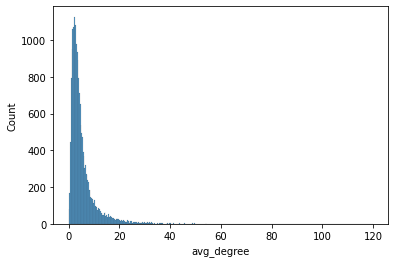

In [88]:
sns.histplot(subreddits_edges_vertices_df['avg_degree'], log_scale=False)

In [89]:
subreddits_edges_vertices_df.describe()

,edges,vertices,avg_degree
count,"20,116.00","20,116.00","20,116.00"
mean,"49,838.25","8,195.46",5.39
std,"875,619.58","72,052.54",5.87
min,1.00,2.00,0.01
25%,539.00,424.00,2.19
50%,"1,391.50",942.00,3.65
75%,"6,588.25","3,043.00",6.22
max,"104,201,471.00","5,465,770.00",119.92


In [90]:
reduced = subreddits_edges_vertices_df[
    (subreddits_edges_vertices_df['vertices']>=30) &
    (subreddits_edges_vertices_df['vertices']<=1500)]
reduced.describe()

,edges,vertices,avg_degree
count,"12,123.00","12,123.00","12,123.00"
mean,"1,098.11",589.02,4.27
std,"1,447.56",367.20,4.34
min,2.00,30.00,0.01
25%,415.00,302.00,2.05
50%,668.00,516.00,3.21
75%,"1,265.00",830.00,4.91
max,"54,143.00","1,500.00",119.92


<AxesSubplot:xlabel='avg_degree', ylabel='Count'>

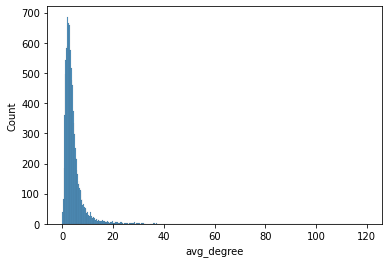

In [91]:
sns.histplot(reduced['avg_degree'], log_scale=False)

In [92]:
import statistics


In [93]:
print("Mode of given data set is % s" % (statistics.mode(reduced.avg_degree)))

Mode of given data set is 4.0


# comapre to barabsi

In [94]:
def _get_avg_degree(g):
    output = 2 * len(g.edges()) / len(g.nodes())
    return output

In [95]:
from networkx.generators.random_graphs import barabasi_albert_graph, erdos_renyi_graph

In [96]:
reddit_sample = subreddits_edges_vertices_df.sample(10)

In [97]:
reddit_sample['avg_degree'].describe()[['mean', '50%']]

mean   4.70
50%    2.92
Name: avg_degree, dtype: float64

In [98]:
sample_sizes = reddit_sample['vertices'].to_list()

In [99]:
sample_sizes

[27, 409, 301, 264, 1832, 1725, 64, 268, 285, 643]

In [104]:
alberts = [barabasi_albert_graph(size, m=1) for size in sample_sizes]

In [107]:
a = pd.DataFrame.from_dict({
        i: {
            'edges':len(g.edges()),
            'vertices':len(g.nodes()),
            'avg_degree':_get_avg_degree(g),
            'deg_distribution': sorted(dict(g.degree()).values()),
            'diff': len(g.nodes())-len(g.edges())}
        for i,g
        in enumerate(alberts)},
    orient='index')

a['deg_mean'] = a['deg_distribution'].apply(lambda x: np.mean(x))
a['deg_q25'] = a['deg_distribution'].apply(lambda x: np.quantile(x, 0.25))
a['deg_q50'] = a['deg_distribution'].apply(lambda x: np.median(x))
a['deg_q75'] = a['deg_distribution'].apply(lambda x: np.quantile(x, 0.75))
a['deg_q100'] = a['deg_distribution'].apply(lambda x: np.quantile(x, 1))

In [108]:
a

,edges,vertices,avg_degree,deg_distribution,diff,deg_mean,deg_q25,deg_q50,deg_q75,deg_q100
0,26,27,1.93,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,1.93,1.00,1.00,2.00,11
1,408,409,2.00,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,2.00,1.00,1.00,2.00,44
2,300,301,1.99,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,1.99,1.00,1.00,2.00,22
3,263,264,1.99,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,1.99,1.00,1.00,2.00,42
4,1831,1832,2.00,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,2.00,1.00,1.00,2.00,129
5,1724,1725,2.00,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,2.00,1.00,1.00,2.00,63
6,63,64,1.97,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,1.97,1.00,1.00,2.00,17
7,267,268,1.99,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,1.99,1.00,1.00,2.00,32
8,284,285,1.99,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,1.99,1.00,1.00,2.00,23
9,642,643,2.00,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,2.00,1.00,1.00,2.00,43


In [203]:
261*3 - 9

774

In [205]:
44180 * 3 - 9

132531

In [189]:
_get_avg_degree(barabasi_albert_graph(3, m=1))

1.3333333333333333

In [192]:
for size in range(100, 10000, 100):
    print(_get_avg_degree(barabasi_albert_graph(size, m=3)))

5.82
5.91
5.94
5.955
5.964
5.97
5.974285714285714
5.9775
5.98
5.982
5.983636363636363
5.985
5.986153846153846
5.9871428571428575
5.988
5.98875
5.989411764705882
5.99
5.990526315789474
5.991
5.991428571428571
5.991818181818182
5.992173913043478
5.9925
5.9928
5.993076923076923
5.993333333333333
5.993571428571428
5.993793103448276
5.994
5.994193548387097
5.994375
5.994545454545454
5.9947058823529416
5.994857142857143
5.995
5.995135135135135
5.995263157894737
5.995384615384616
5.9955
5.995609756097561
5.9957142857142856
5.995813953488372
5.995909090909091
5.996
5.996086956521739
5.996170212765957
5.99625
5.996326530612245
5.9964
5.996470588235294
5.996538461538462
5.996603773584906
5.996666666666667
5.996727272727273
5.996785714285714
5.996842105263158
5.996896551724138
5.996949152542373
5.997
5.997049180327869
5.997096774193548
5.997142857142857
5.9971875
5.997230769230769
5.997272727272727
5.997313432835821
5.99735294117647
5.997391304347826
5.997428571428571
5.997464788732394
5.9975
5.9